# Stroke Prediction
#### Using Deep Neural Networks, Three-Based Metods, and Explainable AI

by ```Eirik Berge```, ```Camilla Idina Jensen Elvebakken```, and ```Martin Ludvigsen```.

## Informaiton About the Data

Stroke is the 2nd leading cause of death globally, and is a disease that affects millions of people every year:

<a href=https://en.wikipedia.org/wiki/Stroke>Wikipedia - Stroke </a>

In this project, we will attempt to classify stroke patients using a dataset provided on Kaggle: 

<a href=https://www.kaggle.com/fedesoriano/stroke-prediction-dataset >Kaggle Stroke Dataset</a>

The dataset consists of over $5000$ individuals and $10$ different input variables that we will use to predict the risk of stroke. The input variables are both numerical and categorical and will be explained below. Some input variables are known risk factors for stroke, like hypertension <a href=https://en.wikipedia.org/wiki/Hypertension>Hyptertension</a> (high blood pressure) and smoking status. In addition, the data set includes some variables that may not traditionally be considered as risk factors: work type and residence type. 

The source and collection methods for the dataset is confidential. In particular, we do not know which countries the participants come from, or if the data originates from medical records or somewhere else. This is problematic as many of the variables are categorical, and it is unclear exactly how the categories were determined or if the different categories were measured at the same time. Notably, it is not clear what type of stroke the dataset is concerned with. One usually subdivides stroke into two categories: Ischemic stroke, which is when the blood supply to the brain is interrupted, and hemorrhagic stroke, which is in part caused by rupturing blood vessels. The fact that the source of the data is confidential also makes it difficult to assess the quality of the data. Another problem with the data is that it is very unbalanced, as there are many more patients without stroke than with stroke. We will attempt to tackle some of these problems in this report.

In this report we will mainly attempt different tree-based methods like random forests and boosting and simple neural networks. We will also spend some time exploring parameter tuning, where we will attempt both gridsearch and Bayesian optimization in order to locate optimal hyperparameters. 

## More on the Different Variables
The dataset contains the following data:

- ```id``` - Integer
- ```gender``` - Categorical: ```male```, ```female``` or ```other```
- ```age``` - Float
- ```hypertension``` - Categorical: ```1``` or ```0```
- ```heart_disease``` - Categorical: ```1``` or ```0```
- ```ever_married``` - Categorical: ```1``` or ```0```
- ```work_type``` - Categorical: ```Private```, ```Self-employed```, ```Govt-job```, ```Never_worked```, ```children```
- ```Residence_type``` - Categorical: ```Urban```, ```Rural```
- ```avg_glucose_level``` - Float
- ```bmi``` - Float
- ```smoking_status``` - Categorical: ```never smoked```, ```formerly smoked```, ```smoking```, ```unknown```
- ```stroke``` - Categorical: ```1``` or ```0```

The variable ```hypertension``` is given as a categorical variable instead of a numerical value containing systolic and diastolic blood pressures. What is considered hypertension depends on age, so having hypertension as a categorical variable might remove the dependency between blood pressure and age, which can make it easier to fit useful models. However, we do not know if hypertensionis determined in a consistent way for all patients, and whether having blood pressure as a float would be more useful. For both hypertension and heart disease, we have no information about the severity of the condition, which is a downside of having only two categorical variables.

On the contrary, ```avg_glucose_level``` and ```bmi``` are given as floats, whereas they could have been encoded as categorical variables like hyperglycemia (<a href=https://en.wikipedia.org/wiki/Hyperglycemia>Wikipedia - Hyperglycemia</a>) and different stages of underweight/overweight, which differs based on age and gender. 

As for ```stroke```, we have no information about what type of stroke the patient suffered from, as we have already mentioned. In addition, we do not have information about the severity of the stroke, or if the patient died directly or indirectly from the stroke.

For the categorical variables ```work_type```, ```ever_married```, ```Residence_type```, and ```smoking_status```, it is uncertain if the categories yield anything more than noise, and if they are useful for predicting stroke. In particular, the categories are not particularly sharp. For example, we do not know the "boundary" between urban and rural residence, or if the patient is currently employed or how long they have been in their current line of work. Smoking status is the only one of these variables that are known to be an important risk factor for stroke. It is therefore problematic that one of the ```smoking_status``` categories is ```unknown```. Keeping the data where smoking status is unknown adds more noise to our data, which can make fitted models less effective. We have a few options for handling this:

- We could remove all the data where smoking status is unknown, which should not be problematic if relatively few patients have unknown smoking status. 

- We could remove the smoking status variable altogether from all patients, which might be helpful if smoking status proves to be noisy.

- We could keep the data as is, and hope the added information of smoking status for some patients outweighs the noise of the patients where smoking status is unknown.

In this report, we choose the last approach. If anything, the problems with the data illustrate the importance of high-quality data collection. 

## Importing Packages

We are going to use various packages, and import them collectively here for convenience.

In [67]:
# Data Handeling
import numpy as np
import pandas as pd

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Basic Machine Learning
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
                             auc, precision_recall_curve, make_scorer, confusion_matrix, plot_roc_curve)
# Deep Learning
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

## Cleaning the Data

We start by cleaning the data and we create dummy variables for some of the variables in the dataset. The data is finally stored in a new CSV-file called ```stroke_clean.csv```.

In [2]:
# Loading in the dataset with Pandas
stroke = pd.read_csv('stroke.csv')

# View the first 3 rows of the dataset
stroke.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


There is already an ```id``` column, so there is no need for a separate index. Hence we make the ```id``` column the index of the dataframe.

In [3]:
# Make the id column the index of the DataFrame
stroke.index = stroke['id']
del stroke['id']

# Make all the column names lowercase
stroke.columns = stroke.columns.str.lower()

The following cell shows that there are some missing values in the ```bmi``` column. Since this is only roughly 4% of the observables, we remove these persons completely.

In [4]:
# Find out where the are missing values
print(stroke.isnull().any())

# Determine the number of missing values
missing_values = stroke['bmi'].isnull().sum()
print(f'\nThere are {missing_values} missing values in the bmi column\n')

# Drop the rows with the missing values
stroke.dropna(inplace=True)

# Check out the datatypes of the data
print(stroke.info())

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

There are 201 missing values in the bmi column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9 

We also see that the columns ```gender```, ```ever_married```, ```work_type```, ```residence_type```, and ```smoking_status``` are of data type <i>object</i>. Let us investigate these columns to see if it is reasonable to convert them to a numeric format.

### Gender

In [5]:
# Check the values present in the gender column
stroke['gender'].value_counts()

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

Since there is only one <i>Other</i>, this will not give us anything statistically significant. 

In [6]:
# Removal of "other"
stroke.drop(stroke[stroke['gender'] == 'Other'].index[0], inplace=True)

# Do a dummy encoding of the genders
stroke['gender'].replace({'Female': 1, 'Male': 0}, inplace=True)

It is interesting to note that more men than women had strokes, even though the average age of women in the study is higher than men.

In [7]:
# More men than women had strokes
stroke.groupby('gender').mean()[['age', 'stroke']]

,age,stroke
gender,,
0,42.049130,0.044257
1,43.437805,0.041422


### Ever Married

In [8]:
# Check the values present in the ever_married column
stroke['ever_married'].value_counts()

Yes    3204
No     1704
Name: ever_married, dtype: int64

Here we only have two categories, and we perform a dummy encoding.

In [9]:
# Do a dummy encoding of the ever_married column
stroke['ever_married'].replace({'Yes': 1, 'No': 0}, inplace=True)

### Work Type

In [10]:
# Check the values present in the ever_married column
stroke['work_type'].value_counts()

Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64

Since there are 5 categories, we dummy encode them into new columns.

In [11]:
# Dummy encoding into 5 columns
dummy_variables = pd.get_dummies(stroke['work_type'])
del stroke['work_type']
 
# Assign new columns to the dataframe
stroke['govt_job'] = dummy_variables['Govt_job']
stroke['never_worked'] = dummy_variables['Never_worked']
stroke['private'] = dummy_variables['Private']
stroke['self-employed'] = dummy_variables['Self-employed']
stroke['children'] = dummy_variables['children']

### Residence Type

In [12]:
# Check the values present in the residence_type column
stroke['residence_type'].value_counts()

Urban    2490
Rural    2418
Name: residence_type, dtype: int64

There are two categories with very similar amounts. We again perform a dummy encoding.

In [13]:
# Do a dummy encoding of the residence_type column
stroke['residence_type'].replace({'Urban': 1, 'Rural': 0}, inplace=True)

### Smoking Status

In [14]:
# Check the values present in the smoking_status column
stroke['smoking_status'].value_counts()

never smoked       1852
Unknown            1483
formerly smoked     836
smokes              737
Name: smoking_status, dtype: int64

Notice that for a lot of the smoker, we only have the status <i>Unknown</i> to work with. Since there is so many of them, we have chosen to not drop the observables. We again perform a dummy encoding.

In [15]:
# Dummy encoding into 4 columns
dummy_variables = pd.get_dummies(stroke['smoking_status'])
del stroke['smoking_status']

# Assign new columns to the dataframe
stroke['never_smoked'] = dummy_variables['never smoked']
stroke['formerly_smoked'] = dummy_variables['formerly smoked']
stroke['smokes'] = dummy_variables['smokes']
stroke['unknown_smoker'] = dummy_variables['Unknown']

Finally, we reorder the columns so that ```stroke```, namely the variable we try to predict, is last.

In [16]:
# Reordering columns
labels = list(stroke.columns)
labels.append('stroke')
del labels[8]
stroke = stroke.reindex(columns=labels)

We save the cleaned data in a CSV file called ```stroke_clean.csv```.

In [17]:
# Saving the data.
stroke.to_csv('stroke_clean.csv')

## Exploratory Data Analysis

Before we start to develop various models, we explore the data to find trends and skewness to keep in mind later. Let us first see how many of the patients have had a stroke:

In [31]:
# Loading back in the cleaned data
stroke_clean = pd.read_csv('stroke_clean.csv', index_col='id')

# Printing out stroke-percentages
print("Percentage of stroke: ", np.round((stroke_clean[stroke_clean.stroke == 1].shape[0]/stroke_clean.shape[0]) * 100, 2), "%")
print("Percentage of non-stroke: ", np.round((stroke_clean[stroke_clean.stroke == 0].shape[0]/(stroke_clean.shape[0]) * 100), 2), "%")

Percentage of stroke:  4.26 %
Percentage of non-stroke:  95.74 %


As we can see above, about 95.7% have not had a stroke. We see that the class distribution is very skewed, which will make this a hard problem, as the model must be sensitive enough to capture the trends of the minority class. We try looking at the stroke distribution among some of the other features in the dataset. 

Text(0.5, 1.0, 'Age/stroke distribution')

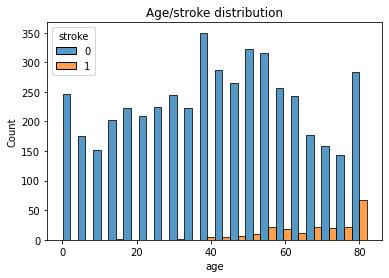

In [37]:
# Visualize the age of people with stroke versus people without stroke
sns.histplot(
    data = stroke_clean,
    x="age", 
    hue="stroke", 
    multiple="dodge"
).set_title("Age/stroke distribution")

We see that more old people than young people have strokes, while we seem to have a good representation of all ages in the dataset. Hence it seems that ```age``` will be an important predictor for predicting ```stroke```.

For the ```smoker``` variable, we have pointed out previously that we are lacking some information due to the <i>Unknown</i> option. We now display how many we are missing

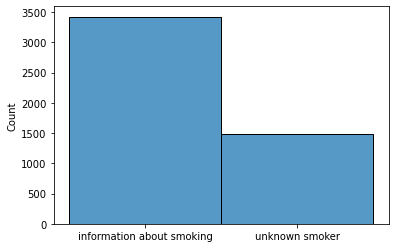

In [35]:
# Show how much information we have about smokers.
information_about_smoker = np.where(stroke_clean.unknown_smoker == 1, "unknown smoker", "information about smoking")
sns.histplot(data=information_about_smoker)
plt.show()

We see that almost one third of our data has smoking status unknown. This is a lot of data, so we coose to include the data with unkown smoking status in our analysis. 

We end this section by showing a heatmap of the correlation between the different variables.

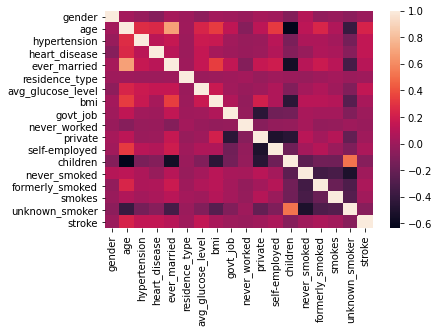

In [40]:
# Correlation heatmap
sns.heatmap(stroke_clean.corr())
plt.show()

We see from the heatmap above that the response ```stroke``` does not seems particularily correlated with any of the predictors. Thus the choice of non-linear models such as ensembles and neural networks is well motivated.

## Utility Functions

Below we define three utility functions that we will use over and over again later in the document:

In [56]:
# Necessary functions for evaluating models
def curves(model_fit, x_test, y_test):
    baseline_probs = [0 for _ in range(len(y_test))]
    probs = model_fit.predict_proba(x_test)[:, 1]

    # calculate scores
    baseline_auc = roc_auc_score(y_test, baseline_probs)
    pc_auc = roc_auc_score(y_test, probs)

    # calculate roc curves
    baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs, drop_intermediate = False)
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    
    axs[0].plot(baseline_fpr, baseline_tpr, linestyle = "--", color = "lightgrey")
    axs[0].plot(fpr, tpr, marker = ".", label = "ROC AUC=%.3f" % (pc_auc), color = "orange")
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC Curve")
    axs[0].legend()
    
    # Calculating precision-recall curves
    probs = model_fit.predict_proba(x_test)[:, 1]
    
    # predict class values
    precision, recall, _ = precision_recall_curve(y_test, probs)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    yhat = model_fit.predict(x_test)
    model_f1, model_auc = f1_score(y_test, yhat), auc(recall, precision)
    
    axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', color = "lightgray")
    axs[1].plot(recall, precision, marker=".", label="f1=%.3f auc=%.3f" % (model_f1, model_auc), color = "orange")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].set_title("Precision-Recall Curve")
    axs[1].legend()
    
    plt.show()

def train_error(model_fit, X_train, y_train):
    train_pred = model_fit.predict(X_train)

    print("Train errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_train, train_pred))
    print("precision: %.3f" % precision_score(y_train, train_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_train, train_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_train, train_pred, zero_division = 0))
    print()
    
def test_error(model_fit, X_test, y_test):
    test_pred = model_fit.predict(X_test)

    print("Test errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_test, test_pred))
    print("precision: %.3f" % precision_score(y_test, test_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_test, test_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_test, test_pred, zero_division = 0))

    cm_test = confusion_matrix(y_test, test_pred)
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cm_test.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm_test, annot=labels, fmt = "", annot_kws={"size": 16}, linewidths = 0.5, cmap="YlGnBu")

## Two Simple Models

To benchmark more complicated models, we have chosen to start with two simple models: A logistic regression model and a simple deep neural network. Let us begin by splitting the data:

In [59]:
# Split into data and response
predictors = stroke_clean.drop('stroke', axis = 1)
response = stroke_clean.stroke

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    predictors, 
    response, 
    test_size=0.25,
    random_state=0
)

### Logistic Regression (with Ridge Penalty)

We use the function ```LogisticRegressionCV``` in the package ```scikit-learn``` to perform a simple logistic regression with Ridge penalty and some cross-validation. We also set the class_weight to <i>balanced</i>. Using the keyword <i>balanced</i> the method will automatically adjust weights which are inversely proportional to the class frequencies in the input data. We will get back to this more with random forests.

One of the nice things about logistic regression is that we only need to tune the ridge parameter, which is done done a lot more effectively than the parameter tuning for the other methods.

In [60]:
# Add Ridge regression with parameter chosen by 10-fold CV
logregfit = LogisticRegressionCV(random_state=0, max_iter=1000, cv=10, class_weight="balanced").fit(X_train, y_train)

# Obtain the coefficients in a table
table_of_coefficients = pd.DataFrame(X_train.columns)
table_of_coefficients["Coefficients"] = logregfit.coef_.transpose()
table_of_coefficients.head()

,0,Coefficients
0,gender,0.080224
1,age,0.079782
2,hypertension,0.622005
3,heart_disease,0.243135
4,ever_married,-0.040349


The basic accuray of the logistic model is reported below on both the training set and the test set. As can be seen, we obtain better test accuracy than training accuracy, and both are very high already.

In [61]:
print("Train accuracy: ", logregfit.score(X_train, y_train))
print("Test accuracy: ", logregfit.score(X_test, y_test))

Train accuracy:  0.7462646020103233
Test accuracy:  0.7294213528932355


We now plot the ROC curve and the Precision-Recall Curve for the logistic regression.

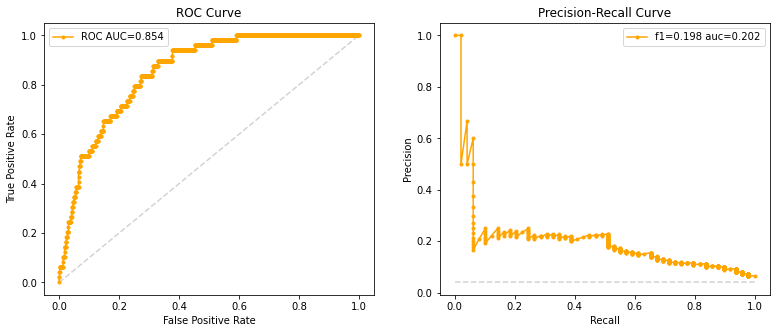

Test errors:

accuracy: 0.729
precision: 0.112
recall: 0.837
f1: 0.198


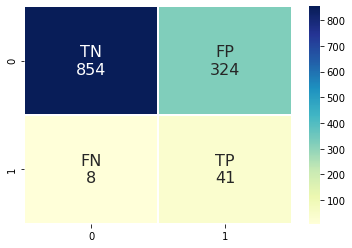

In [63]:
# Plotting the curves
curves(logregfit, X_test, y_test)

# Displaying test-errors
test_error(logregfit, X_test, y_test)

Investigating the ROC-curve we see that even when using the "balanced" weighting the curve is skewed towards the upper right, indicating that true positives comes heavily at the cost of false positives. This is mainly because our dataset is unbalanced, and we will see this trend for essentially all models.

### A Simple Deep Neural Network

We also investigate the effectiveness of a simple deep neural network. To do this, we use the package ```keras```. We begin by scaling the data and making the various layers in the neural network.

In [22]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Making the layers
model = keras.models.Sequential([
    keras.layers.Input(shape=[17]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

# Checking out the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1800      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,001
Trainable params: 12,001
Non-trainable params: 0
_________________________________________________________________


Below we compile and fit the neural network. Note that we have made a weight called ```class_weight``` that ensures that the model focus on classifying the true positives correctly, with the understanding that this will most likely cause the false-positive rate to also increase.

In [23]:
# Compiling the model
model.compile(
    loss="binary_crossentropy",
    optimizer='SGD',
    metrics=[keras.metrics.Recall(), keras.metrics.Precision(), 'accuracy']
)

# Choosing a weight
class_weight = {0: 1., 1: 50.}

# Fitting the model
model.fit(X_train, y_train, class_weight=class_weight, epochs=5)

Epoch 1/5
116/116 [==============================] - 0s 1ms/step - loss: 1.7689 - recall: 0.9062 - precision: 0.0542 - accuracy: 0.3083  
Epoch 2/5
116/116 [==============================] - 0s 1ms/step - loss: 1.5765 - recall: 0.9375 - precision: 0.0673 - accuracy: 0.4325
Epoch 3/5
116/116 [==============================] - 0s 1ms/step - loss: 1.4588 - recall: 0.9250 - precision: 0.0764 - accuracy: 0.5107
Epoch 4/5
116/116 [==============================] - 0s 1ms/step - loss: 1.5279 - recall: 0.9000 - precision: 0.0759 - accuracy: 0.5197
Epoch 5/5
116/116 [==============================] - 0s 1ms/step - loss: 1.4593 - recall: 0.9312 - precision: 0.0784 - accuracy: 0.5211  


We have made a model that emphasizes maximizing recall. This comes, due to the skewness of our data, at the cost of having low accuracy and horrible precision. Such a model can be useful as a preliminary test, where one gets many fasle positves but catches most true positives.

In [42]:
# Testing the model
results = model.evaluate(X_test, y_test)

print("\nRecall: ", round(results[1], 3))
print("Precision: ", round(results[2], 3))
print("Accuracy: ", round(results[3], 3))

39/39 [==============================] - 0s 997us/step - loss: 0.7636 - recall: 0.9796 - precision: 0.0780 - accuracy: 0.5371

Recall:  0.98
Precision:  0.078
Accuracy:  0.537


## Discussion on Evaluating Performance and Hyperparameters

### Evaluating Performance

The skewness in the data for the response is typical in medical datasets that deals with prediction of rare occurrences like stroke. We will always have many more examples of people without the condition, than with, making it very dificult to correctly identify the general pattern behind the minority class. In addition, with skewed medical datasets like this one, false negative rates and false positive rates do not have equal weight. In our dataset, a false negative will be much more dangerous than a false positive, as it is better to predict that someone will get a stroke and get it wrong, than the other way around.

For binary classification problems it is typical to use accuracy as the metric to evaluate performance of the method. Accuracy is the ratio of the correctly predicted observations to the total number of observation. With an imbalanced problem like the one we have, accuracy will not be a good preformance measure. To show why, if we simply make a classification model which predicts all observations as class 0, "no stroke", we will get a very high accuracy which will not reflect the difference in size between the two classes.

\begin{align*}
    \text{accuracy} = \frac{\text{tp + tn}}{\text{tp + tn + fn + fp}} = \frac{4699 + 0}{4699 + 0 + 209 + 0} = 0.957
\end{align*}

Other measures which are better with dealing with unsymmetric classes are precision and recall. Precision is the ratio of correctly predicted positive observations to the total number of predicted positive observations. Precision favors a low false positive rate. Recall is the ratio of correctly predicted positive observations to all the observations in the actual class. This favors the false negative rate, which is important when we want to minimize the number of false negatives. Both of these metrics would becomes zero in the case above.

\begin{align*}
    \text{precision} = \frac{\text{tp}}{\text{tp + fp}}, \quad \text{recall} = \frac{\text{tp}}{\text{tp + fn}}
\end{align*}

To be able to take into account both recall and precision, we can use the f1-measure, which is the harmoic mean of precision and recall:

\begin{align*}
    \text{f1} = \frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision + recall}}
\end{align*}

Instead of using the predicted values from using the threshold 0.5, we could also calculate both ROC-AUC and precision-recall-AUC to find better thresholds. ROC-AUC is the area under the ROC curve which plots the true positive rate against the false positive rate. The precision-recall curve uses precision instead of false positive rate, and can be considered better in the case when we have an unproportional large amount of true negatives, since neither recall or precision takes this into account.

Sklearn also icludes several metric which tries to balance out the classes during evaluation. For evaluating our models we will use the balanced accuracy score, which is defined as the average of recall obtained on each class: 

<a href=https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html>Scikit-Learn - Balanced Accuracy </a> 

We will show this produces good results. Using this metric during the hyperparameter tuning of the models, the goal is that the models will favor decreasing the amount of false negatives over increasing the amount of true negatives. This might push more observations into false positives, but considering the real world implications of false negatives in stroke predictions, this is an acceptable trade-off.

### Hyperparameter tuning

Most of the models we will apply will need some hyperparameter tuning in order to be effective. Hyperparameters are essentially all parameters that we pass to the function that fits a model. What we consider hyperparameters will become evident when discussing the different models. The goal of hyperparameter tuning is to select hyperparameters so that the model maximizes some metric. For essentially all models we use the "balanced_accuracy" metric for tuning our models. 

In statistical learning and machine learning, the the hope is that most model are stable in the hyperparameters, meaning that small changes in hyperparameters yield similar results. This is however not always the case, and hyperparameter tuning is necessary.

Different hyperparameters also allow us to tune models to be more balanced. However, we will see that in order to get good results for this problem, one should start with a balanced model instead of tuning an unbalanced model to be more balanced. 

Hyperparameter tuning is a difficult optimization problem. It is difficult because we usually have no mathematical expression for how different hyperparameters affect the metric. This means that we have no information about gradients, and the problem is most likely non-convex. Furthermore, function evaluations, which here corresponds to fitting a model with certain hyperparameters, are usually expensive. For tree-models, many hyperparameters are discrete, and if we change one hyperparameter we usually have to refit the entire model. This is different from for example lasso regression, where model fits are (usually) continuous with respect to the regularization parameter, and one fit can be used to quickly find the next fit. This is also the case for some tree-model hyperparameters, but this is not necessarily taken into account by the methods we use to search for hyperparameters. 

We will use two different methods for hyperparameter tuning: Grid search and Bayesian search. 
Grid search fits models using a grid of hyperparameters, at each point applying CV to get an estimate of the metric, and selects the model that gives the best result. 

- Grid search is simple, easy to parallelize and requires essentially no cost other than fitting the models.
- One of the drawbacks is that we have to preselect a grid, which can either be too coarse, leading to a bad result, or too fine, leading to long computation times. 
- Another problem with preselecting a grid is that the optimal hyperparameters do not necessarily lie inside the preselected grid, meaning that grid search is not entirely automatic.

The grid search we will use is the ```GridSearchCV``` function in the sklearn library. 

Bayesian search uses Bayesian optimization to find optimal hyperparameters. We will not go into detail about Bayesian optimization here, but we will mention some pros and cons. 

- The main appeal of Bayesian optimization is that it searches for a good solution in a much smarter way than grid search. 
- It is able to handle local minimizers, which is something traditional optimization methods usually struggle with.
- We can select prior distributions for the hyperparameters, and the result can be considered a posterior distribution. Thus, we can actually do some inference with our hyperparameters.
- The implementation that we will use, ```BayesianSearchCV``` from the scikit optimize library, is currently under development, and not particularily fast or well-documented. The extra cost of searching for good hyperparameters to test most likely outweigh the cost of just testing more "bad" hyperparameters, which is especially the case if fitting the models is cheap. 
- Bayesian optimization is also mainly effective for continuous, not discrete, variables. It is unknown to us how the implementation we use handles discrete variables. Bayesian optimization also has the problem of requiring a preselected grid where we search for solutions.

For both grid search and Bayesian search, the implementations we are using are rather lacking in that it is difficult to interpret the results. It is not impossible, but it requires some extra work that we are not interested in doing here. It would be interesting to investigate how stable different methods are with respect to different hyperparameters and which hyperparameters are important.

## Tree-Based Models

We now test various tree-based methods to see how they perform. We begin with a simple decision tree.

### Decision tree

For tree-based models, we start by implementing a simple decision tree to get a baseline test error for our models to see if the more advanced ensemble methods and the neural network can actually improve predictions for this very imbalanced dataset. To search for the optimal hyperparameters we use a gridsearch using sklearn's $```GridSearchCV```$. To use this method we must define a grid of hyperparameter values for the method to test.  For the decision tree we decide to include the hyperparamters ```criterion```, ```max_depth```, ```min_samples_split``` and ```min_samples_leaf```. There are more hyperparameters to tune, and we are not certain if these are the best parameters to tune. In fact, the more parameters we tune, the more likely it is that we do a lot of unecessary calculations.

We will first implement the decision tree using accuracy as the scoring metric, to show that this does not yield optimal results.

In [71]:
# Setting up parameters
parameters = {
    "criterion": ["gini", "entropy"], 
    "max_depth": range(1, 8, 1),          
    "min_samples_split": range(2, 8, 1),
    "min_samples_leaf": range(1, 8, 1)
    }

# Creating the decision tree
decisiontree = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 23),
    param_grid = parameters,
    scoring = "accuracy",
    cv = 3
)

# Fit the desicion tree
decisiontree_fit = decisiontree.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameter:")
print(decisiontree_fit.best_params_)

Best hyperparameter:
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


We see that the best hyperparameters yield an extremely shallow tree with a maximum depth of 1. From the resulting decision tree above we see that the tree does not manage to correctly classify many of the observations from the minority class. We calculate the test error below.

Test errors:

accuracy: 0.960
precision: 0.000
recall: 0.000
f1: 0.000


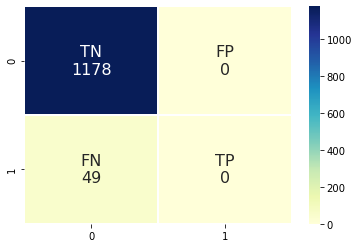

In [72]:
# Display test error statistics
test_error(decisiontree_fit, X_test, y_test)

From the confusion matrix above we see that the method does not manage to predict a single true positive case, but still gets a accuracy of $\sim 96\%$. As the good statisticians we are, we are not fooled by the good accuracy, and try use the "balanced accuracy" as the scoring metric in the hyperparameter tuning from now on.

For each model we also plot the ROC and precision-recall curves to see how these changes with the different methods. When using a different metric we expect the ROC-AUC score to becomes worse, but hopefully the PR-AUC score will increase.

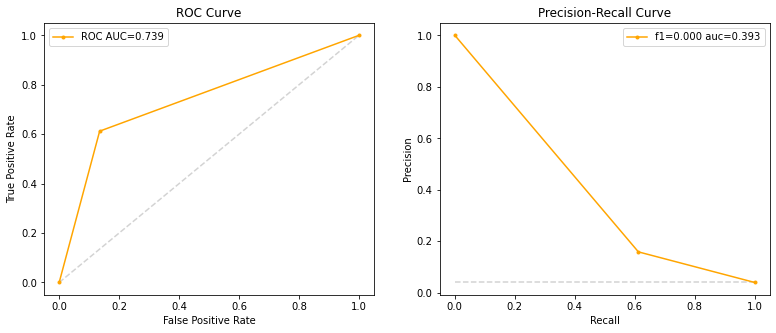

In [74]:
# Plot ROC and Precision-Recall Curve
curves(decisiontreefit, X_test, y_test)

We train the decision tree again, this time with the "balanced accuracy" score. We also allow the ```class_weight``` to be "balanced" in out hyperparameter tuning.

In [78]:
# Setting up parameters
parameters = {
    "criterion": ["gini", "entropy"], 
    "max_depth": range(1, 8, 1),
    "min_samples_split": range(2, 8, 1),
    "min_samples_leaf": range(1, 8, 1),
    "class_weight": [None, "balanced"]
}

# Creating the decision tree
balanced_tree = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 23),
    param_grid = parameters,
    scoring = "balanced_accuracy", 
    cv = 3
)

# Fit the desicion tree
balanced_tree_fit = balanced_tree.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameters:")
print(balanced_tree_fit.best_params_)

Best hyperparameters:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


Test errors:

accuracy: 0.522
precision: 0.074
recall: 0.959
f1: 0.138


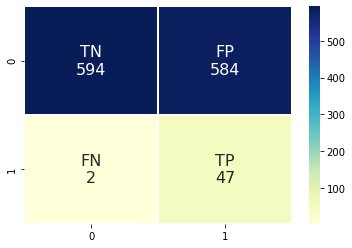

In [80]:
# Display test error statistics
test_error(balanced_tree, X_test, y_test)

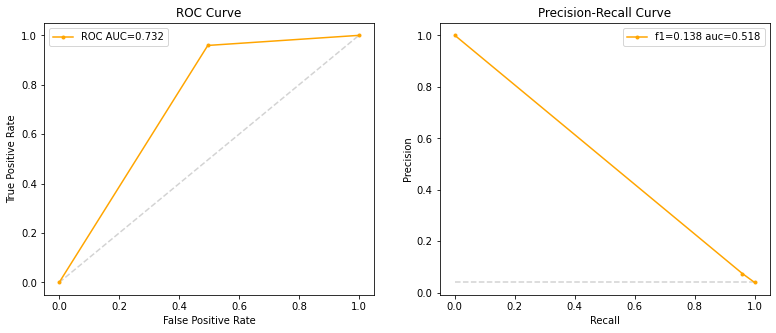

In [81]:
# Plot ROC and Precision-Recall Curve
curves(balanced_tree, X_test, y_test)

Using the different scoring metric, we have managed to get a better recall, at the expense of many more false positive predictions and a much lower accuracy. Being able to classify true positives comes heavily at the cost of producing false negatives. We see from the hyperparameter tuning that a deeper tree is now necessary. 

### Random Forests